In [1]:
from typing import Callable

import torch
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale as preprocessing_scale
import pandas

In [2]:
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

default_device = "cpu"
if torch.cuda.is_available():
    default_device = "cuda"

torch.set_default_device(default_device)

In [3]:
data = pandas.read_csv('../datasets/graduate_admission.csv')
data.describe()

,id,GRE,TOEFL,university_rating,SOP,LOR,CGPA,has_research,score
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


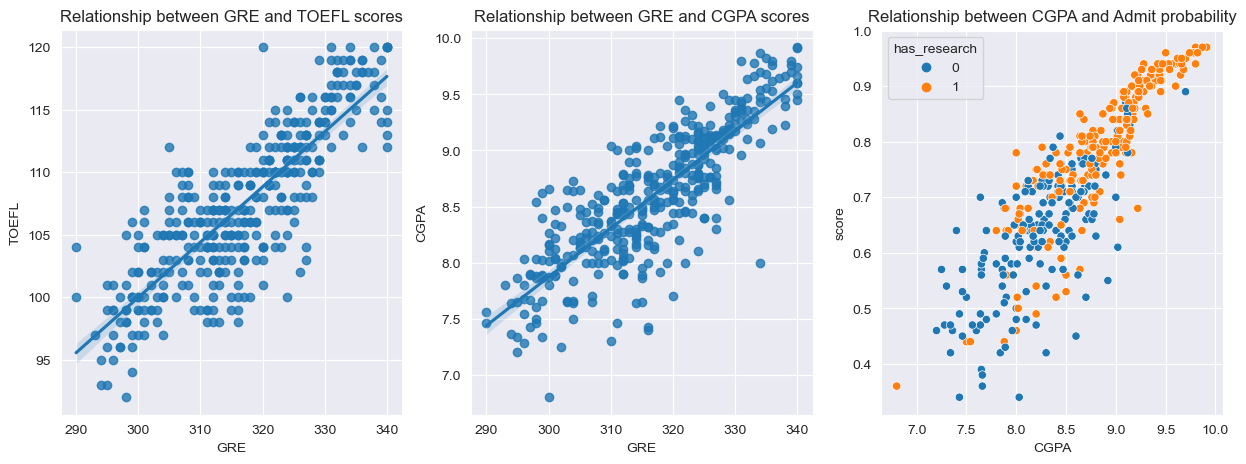

In [4]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

seaborn.regplot(x="GRE", y="TOEFL", data=data, ax=axs[0])
axs[0].set_title("Relationship between GRE and TOEFL scores")

seaborn.regplot(x="GRE", y="CGPA", data=data, ax=axs[1])
axs[1].set_title("Relationship between GRE and CGPA scores")

seaborn.scatterplot(x="CGPA", y="score", hue="has_research", data=data, ax=axs[2])
axs[2].set_title("Relationship between CGPA and Admit probability")

plt.show()

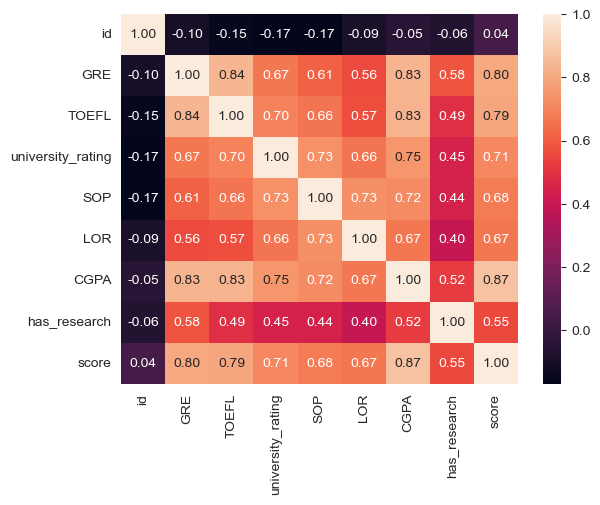

In [5]:
plt.figure()
seaborn.heatmap(data.corr(), annot=True, fmt='.2f')
plt.show()

In [6]:
# Subtract the mean and divide by the standard deviation
# It is found that neural networks perform better in training and prediction when they work with standardized features.
feature_columns = ['GRE', 'TOEFL', 'SOP', 'LOR', 'CGPA']
features = preprocessing_scale(data[feature_columns])

category_bounds = [0, 0.59, 0.79, 1]
category_labels = [0, 1, 2]
labels = pandas.cut(data['score'], category_bounds, labels=category_labels)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, labels.values, test_size=0.2)

x_train_tensor = torch.tensor(x_train, dtype=default_dtype)
x_test_tensor = torch.tensor(x_test, dtype=default_dtype)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

In [8]:
input_size = x_train_tensor.shape[1]
output_size = len(category_labels)

class Network(torch.nn.Module):
    def __init__(self, hidden_size: int, activation_func: Callable[[torch.Tensor], torch.Tensor] = torch.nn.functional.relu, dropout: float = 0):
        super(Network, self).__init__()

        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, output_size)

        self.activation_func = activation_func
        self.hidden_size = hidden_size
        self.dropout = None if dropout == 0 else torch.nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        x = self.activation_func(self.layer1(x))
        x = self.activation_func(self.layer2(x))

        if self.dropout is not None:
            x = self.dropout(x)

        x = self.layer3(x)
        return torch.nn.functional.log_softmax(x, dim=-1)

In [9]:
def visualize_training_process(epoch_data) -> None:
    ed_fig, ed_axs = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

    epoch_data_df = pandas.DataFrame(epoch_data, columns=["train_loss", "test_loss", "test_accuracy"])
    epoch_data_df[["train_loss", "test_loss"]].plot(ax=ed_axs[0])
    epoch_data_df[["test_accuracy"]].plot(ax=ed_axs[1])

    plt.show()

In [10]:
def train_model(model: torch.nn.Module, epochs = 10000, learning_rate = 1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    cost_func = torch.nn.NLLLoss()

    epoch_data = []
    for i in range(epochs):
        optimizer.zero_grad()

        model.train()
        train_prediction = model(x_train_tensor)
        train_loss = cost_func(train_prediction, y_train_tensor)
        train_loss.backward()

        optimizer.step()

        model.eval()
        eval_prediction = model(x_test_tensor)
        test_loss = cost_func(eval_prediction, y_test_tensor)

        max_values, max_indices = torch.max(eval_prediction, dim=1)
        test_accuracy = torch.sum(torch.eq(max_indices, y_test_tensor)).item() / y_test.size

        epoch_data.append([train_loss.item(), test_loss.item(), test_accuracy])

    visualize_training_process(epoch_data)

Hidden size: 100, Activation function: sigmoid, No dropout


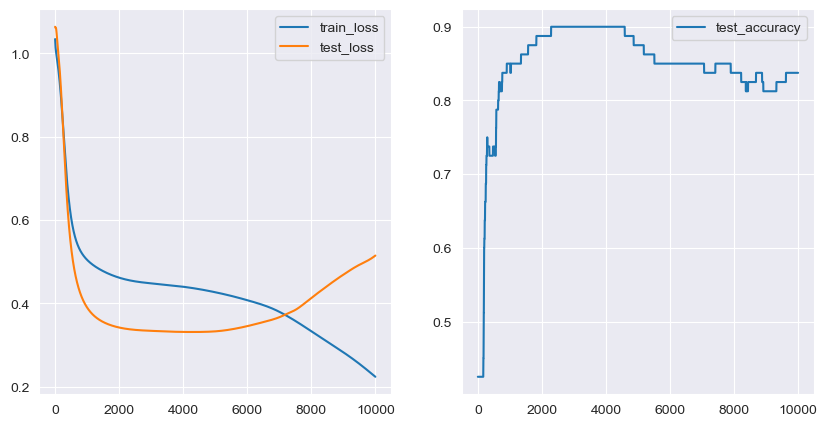

In [11]:
print('Hidden size: 100, Activation function: sigmoid, No dropout')
network1 = Network(hidden_size=100, activation_func=torch.nn.functional.sigmoid)
train_model(network1)

Hidden size: 100, Activation function: sigmoid, Dropout: 0.2


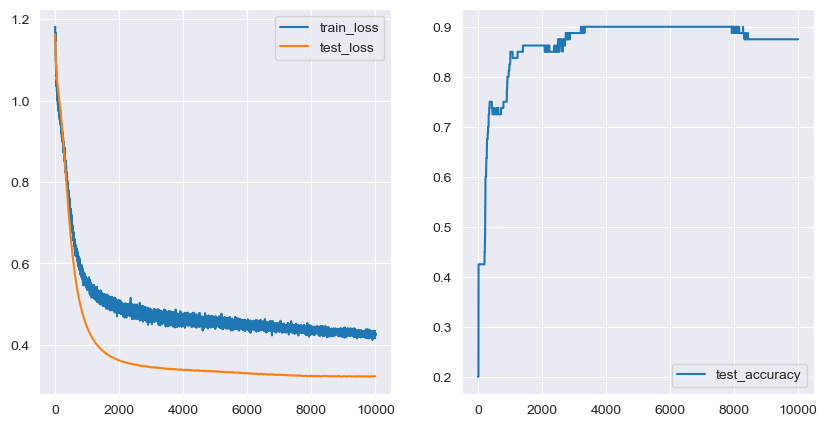

In [12]:
print('Hidden size: 100, Activation function: sigmoid, Dropout: 0.2')
network2 = Network(hidden_size=100, activation_func=torch.nn.functional.sigmoid, dropout=0.2)
train_model(network2)

Hidden size: 50, Activation function: tanh, No dropout


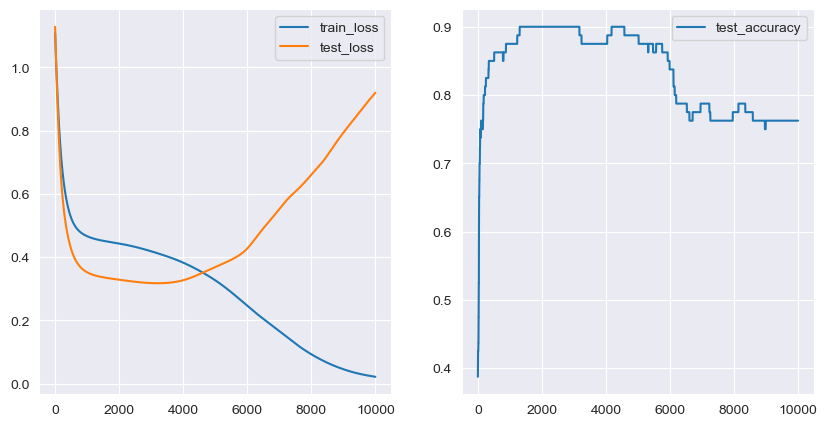

In [13]:
print('Hidden size: 50, Activation function: tanh, No dropout')
network3 = Network(hidden_size=50, activation_func=torch.nn.functional.tanh)
train_model(network3)

Hidden size: 1000, Activation function: tanh, No dropout


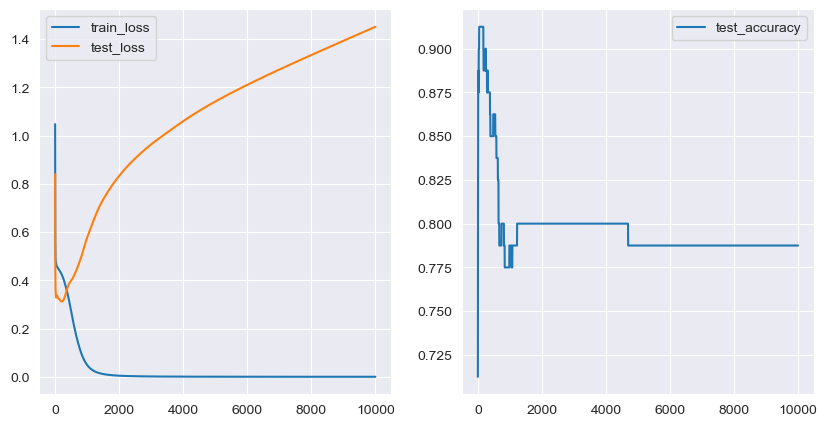

Hidden size: 1000, Activation function: tanh, Dropout: 0.2


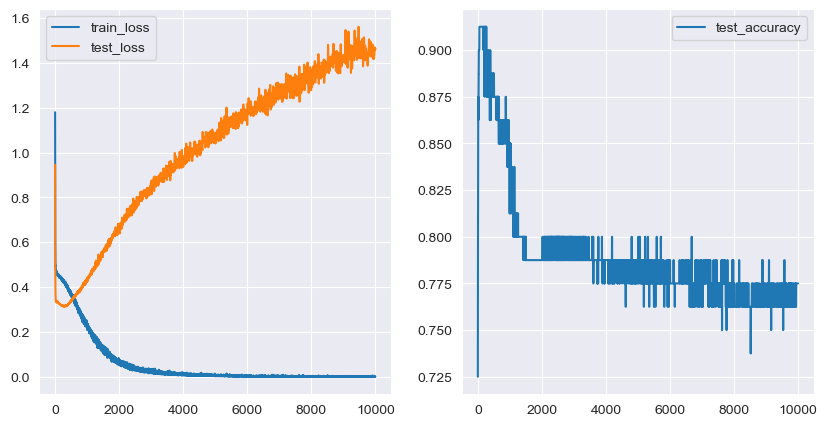

In [14]:
# We should note that if we have a simple dataset but not many records, making a model more complex will not help
print('Hidden size: 1000, Activation function: tanh, No dropout')
network4 = Network(hidden_size=1000, activation_func=torch.nn.functional.tanh)
train_model(network4)

print('Hidden size: 1000, Activation function: tanh, Dropout: 0.2')
network5 = Network(hidden_size=1000, activation_func=torch.nn.functional.tanh, dropout=0.2)
train_model(network5)